# GREEN$ ePIS gift procurement cost

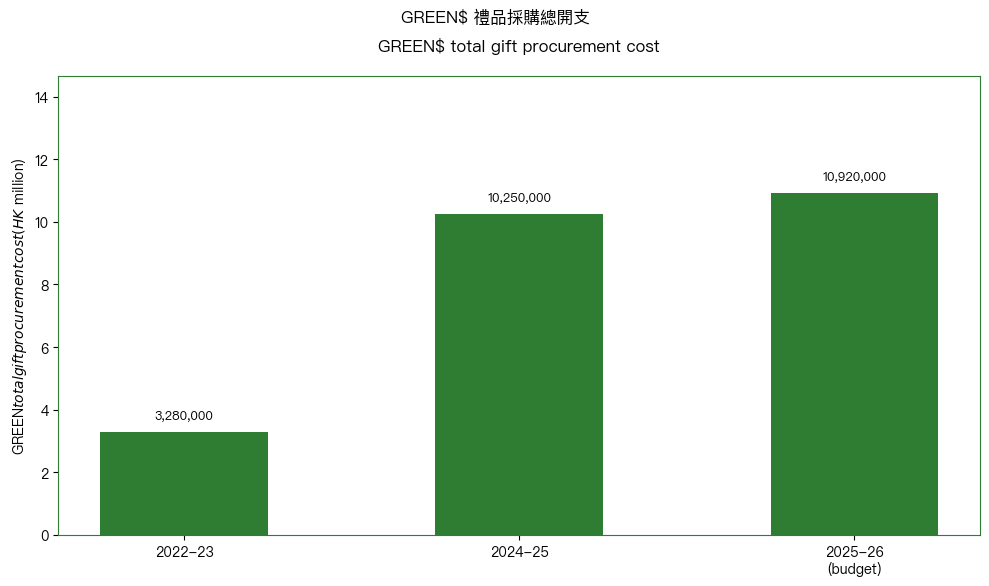

In [1]:
# ---------- install deps if missing ----------
import importlib, subprocess, sys
def _ensure(pkg, mod=None):
    try:
        importlib.import_module(mod or pkg)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

_ensure("pandas")
_ensure("openpyxl")
_ensure("matplotlib")

# ---------- imports ----------
import re
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from pathlib import Path

# ---------- load data (note: specific sheet) ----------
data_path = Path("../General Stats_G@C_clean.xlsx")
df = pd.read_excel(data_path, sheet_name="G@C Recyclables Collection Volu", engine="openpyxl")

# ---------- helper to find columns by header pattern ----------
def find_col(columns, patterns):
    cols = [(c, re.sub(r"\s+", " ", str(c)).strip()) for c in columns]
    for c, norm in cols:
        if any(re.search(p, norm, flags=re.IGNORECASE) for p in patterns):
            return c
    return None

year_col_patterns = [r"^year$"]
gift_col_patterns = [r"green\$.*total\s+gift\s+procurement\s+cost"]

year_col = find_col(df.columns, year_col_patterns)
gift_col = find_col(df.columns, gift_col_patterns)

if year_col is None or gift_col is None:
    raise RuntimeError("Could not find Year or GREEN$ total gift procurement cost columns.")

# ---------- clean / subset data ----------
gift_series = df[gift_col]
mask = gift_series.notna() & gift_series.astype(str).str.strip().ne("")

sub = df.loc[mask, [year_col, gift_col]].copy()

# clean numeric values (remove commas -> float)
sub[gift_col] = (
    sub[gift_col]
    .astype(str)
    .str.strip()
    .str.replace(",", "", regex=False)
    .astype(float)
)

years = sub[year_col].astype(str).str.strip().tolist()
values = sub[gift_col].tolist()  # actual HK$ values

# format last label as two lines if it contains "(budget)"
formatted_years = []
for y in years:
    if "(budget)" in y:
        # turn "2025-26 (budget)" into "2025-26\n(budget)"
        y = y.replace(" (budget)", "\n(budget)")
    formatted_years.append(y)

# convert to millions for axis scaling
values_million = [v / 1_000_000 for v in values]

# ---------- fonts (Chinese-capable if available) ----------
for font_name in ["Noto Sans CJK TC", "PingFang TC", "PingFang HK",
                  "Microsoft JhengHei", "SimHei"]:
    if any(font_name in f.name for f in matplotlib.font_manager.fontManager.ttflist):
        plt.rcParams["font.family"] = font_name
        break
plt.rcParams["axes.unicode_minus"] = False

# ---------- plot vertical green bar chart ----------
fig, ax = plt.subplots(figsize=(10, 6), facecolor="white")
ax.set_facecolor("white")

x = list(range(len(formatted_years)))
bar_color = "#2e7d32"  # green

# green border for axes
for spine in ax.spines.values():
    spine.set_color(bar_color)

bar_width = 0.5  # creates space between bars
bars = ax.bar(x, values_million, width=bar_width, color=bar_color)

max_val = max(values_million) if values_million else 0
ax.set_ylim(0, max_val * 1.25 + 1)

# add value labels (full HK$ with commas) above each bar
for xi, v_m, v_raw in zip(x, values_million, values):
    ax.text(
        xi,
        v_m + max_val * 0.03,
        f"{v_raw:,.0f}",
        ha="center",
        va="bottom",
        fontsize=9,
    )

ax.set_xticks(x)
ax.set_xticklabels(formatted_years, rotation=0, ha="center")

ax.set_ylabel("GREEN$ total gift procurement cost (HK$ million)")

title_cn = "GREEN$ 禮品採購總開支"
title_en = "GREEN$ total gift procurement cost"
fig.suptitle(title_cn, y=0.97)
ax.set_title(title_en, pad=18)

plt.tight_layout()
plt.show()
